In [1]:
import ROOT as rt
import csv
import sys
import collections
import os
from collections import OrderedDict
import uproot

import numpy as np

sys.path.append(os.getcwd().replace('scripts', 'lib'))

import tdrstyle
tdrstyle.setTDRStyle()



print(sys.version)

Welcome to JupyROOT 6.28/00
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


In [2]:
def readNorm(f_cscCard):
    f = open(f_cscCard,"r")
    Lines = f.readlines()
    for line in Lines:
        l  = line.split()
        if len(l) == 0:continue
        if l[0] == 'rate':
            return float(l[1])

# Load limit trees
Here you will read the limit trees and create an array `limits` that stores 6 number for each LLP lifetimes
You will also need to divide the limit from limit trees by the norm that you've set when you ran Combine

In [5]:
dataCardDir = '/uscms_data/d3/christiw/CMSSW_11_3_4/src/MDS_CMSDAS2023/combine/datacards/'
limitDir = '/uscms_data/d3/christiw/CMSSW_11_3_4/src/MDS_CMSDAS2023/combine/limitTrees/'
ctaus = np.array([10, 50, 100, 500, 1000,5000, 10000, 50000, 100000,int(2e5),int(3e5),int(5e5), \
                        int(2e6),int(3e6),int(5e6),int(1e7)])


limitTrees = {}
dataCards = {}
limits = np.ones((len(ctaus), 6))*1000000

for ct in ctaus:
    name = 'ggH_HToSSTobbbb_mh125_mx40'
    dataCards[ct] = dataCardDir + '/'+name+'_ctau'+str(ct)+'mm.txt'
    limitTrees[ct] = limitDir + '/'+'/higgsCombine.'+name + '_ctau'+str(ct)+'mm.AsymptoticLimits.mH120.root'
for i,m in enumerate(limitTrees.keys()):
    if not os.path.isfile(dataCards[m]):
        print(dataCards[m])
        continue
    signal_norm = readNorm(dataCards[m])
    if signal_norm == 0:continue
    if len(uproot.open(limitTrees[m]).keys()) == 2:
        T = uproot.open(limitTrees[m])['limit']
        limits[i] = np.array(T['limit'].array())/signal_norm
limits = np.array(limits)

print(ctaus)



[      10       50      100      500     1000     5000    10000    50000
   100000   200000   300000   500000  2000000  3000000  5000000 10000000]


# Plotting expected and observed Limit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


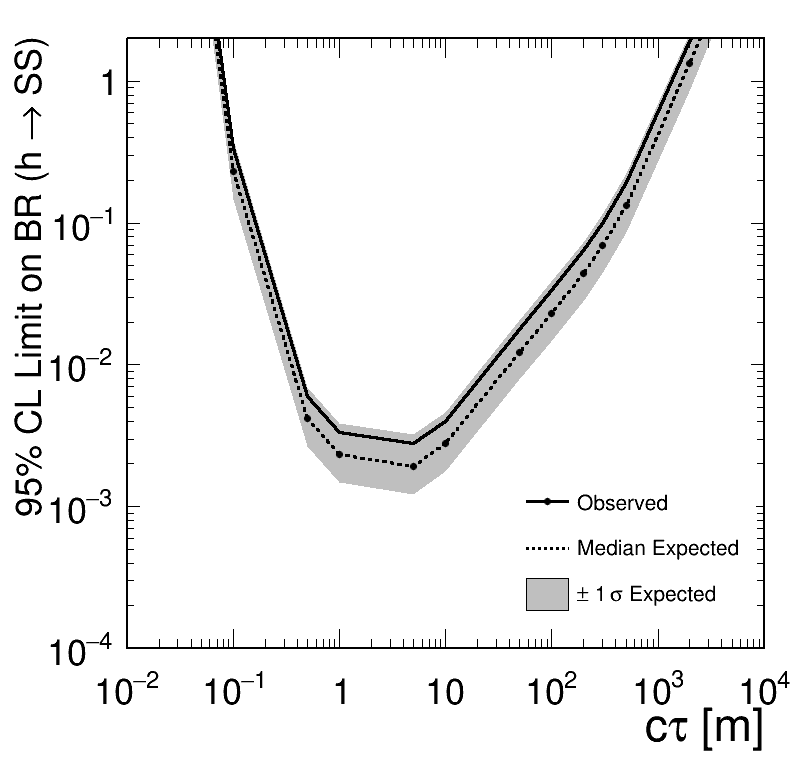

In [6]:
opac_1sig = 0.25


leg = rt.TLegend(0.65,0.2,0.95,0.38)



leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg.SetTextFont(42)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000

cond = limits[:,2] < 1000000


h = rt.TGraph(len(ctaus_m[cond]),ctaus_m[cond], limits[:,2][cond])
h_obs = rt.TGraph(len(ctaus_m[cond]),ctaus_m[cond], limits[:,5][cond])
h_exp1sig = rt.TGraph(2*len(ctaus_m[cond]), np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[:,1][cond], np.flip(limits[:,3][cond]))))

leg.AddEntry(h_obs, "Observed", "LP")
leg.AddEntry(h, "Median Expected", "L")
leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')

h_exp1sig.SetFillColorAlpha(1,opac_1sig)
h.SetLineColor(1)
h_obs.SetLineColor(1)
h_obs.SetMarkerColor(1)


h_obs.SetLineWidth(3)

h.SetLineStyle(2)
h.SetLineWidth(3)
h.GetXaxis().SetTitle('c#tau [m]')
h.GetYaxis().SetTitle('95% CL Limit on BR (h #rightarrow SS)')
h.GetXaxis().SetLimits(0.01,10000.0)
h.GetYaxis().SetRangeUser(5e-4,50)
h.GetYaxis().SetRangeUser(1e-4,2)

h.GetXaxis().SetTitleOffset(1)
h.GetYaxis().SetTitleSize(0.05)
h.GetYaxis().SetTitleOffset(1.5)

h.Draw('LPA')
h_obs.Draw('Lsame')
h_exp1sig.Draw('Fsame')


leg.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)


latex = rt.TLatex()
latex.SetTextSize(0.06)
latex.SetTextFont(42)


tdrstyle.setTDRStyle()
c.Draw()
